# Publication-ready path density figure

This notebook shows how to create a path density plot with custom ticklabels, states shown as shaded regions, and representative trajectories.

Most of this just illustrates some fancier things that can be done with matplotlib, and isn't specific to OpenPathSampling.

In [1]:
import openpathsampling as paths
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

from openpathsampling.numerics import HistogramPlotter2D

In [2]:
%%time
flexible = paths.Storage("ad_tps.nc", mode='r')

CPU times: user 12.5 s, sys: 1.31 s, total: 13.8 s
Wall time: 13.8 s


In [3]:
psi = flexible.cvs['psi']
phi = flexible.cvs['phi']
deg = 180.0 / np.pi

In [4]:
path_density = paths.PathDensityHistogram(cvs=[phi, psi],
                                          left_bin_edges=(-180/deg,-180/deg),
                                          bin_widths=(2.0/deg,2.0/deg))

In [5]:
# it takes a little time to load the trajectories from disk
trajectories = [s.active[0].trajectory for s in tqdm(flexible.steps)]

In [6]:
path_dens_counter = path_density.histogram(trajectories)

In [7]:
tick_labels = np.arange(-np.pi, np.pi+0.01, np.pi/4)
plotter = HistogramPlotter2D(path_density, 
                             xticklabels=tick_labels,
                             yticklabels=tick_labels, 
                             label_format="{:4.2f}")

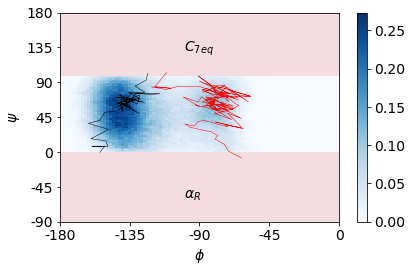

In [8]:
# this is the figure we actually publish
# change xlim and ylim (which are in radians) to get the figure you want
xlim = (-np.pi, 0)
ylim = (-np.pi/2, np.pi)
#xlim = ylim = (-np.pi, np.pi)

state_color = (0.953, 0.867, 0.878)
plt.rcParams.update({'font.size': 14})

# main plotting
ax = plotter.plot(xlim=xlim, ylim=ylim, cmap="Blues")
trajA = flexible.steps[1000].active[0].trajectory
trajB = flexible.steps[6500].active[0].trajectory
plotter.plot_trajectory(trajA, '-k', lw=0.5)
plotter.plot_trajectory(trajB, '-r', lw=0.5)
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")

# adding something to show the states
alpha_R_xywh = (-180, -100, 180, 100)

# our states are rectangular, so we make rectangular patches
from matplotlib.patches import Rectangle
def state_patch(x, y, w, h):
    xy = np.array([x, y]) / deg
    wh = np.array([w, h]) / deg
    plot_xy = [plotter.to_bins(val, i) 
               for (i, val) in enumerate(xy)]
    plot_w, plot_h = wh / plotter.histogram.bin_widths
    return Rectangle(plot_xy, plot_w, plot_h, color=state_color)

ax.axes.add_patch(state_patch(-180, -100, 180, 100))  # alpha_R
ax.axes.add_patch(state_patch(-180, 100, 180, 100))   # C7eq
ax.axes.add_patch(state_patch(-180, -260, 180, 100))  # C7eq, wrapped around

plt.text(x=plotter.to_bins(-100/deg, 0), 
         y=plotter.to_bins(-60/deg, 1),
         s="$\\alpha_R$")
plt.text(x=plotter.to_bins(-100/deg, 0),
         y=plotter.to_bins(130/deg, 1),
         s="$C_{7eq}$")

# now we're going to clean up so our axes are in degrees
# save limits
xlim = plt.xlim()
ylim = plt.ylim()

# convert labels back to degree
def degree_ticks(locs_labels):
    locs, labels = locs_labels
    new_labels = []
    for label in labels:
        numeric = float(label.get_text())
        label.set_text("{:.0f}".format(numeric*deg))
        new_labels.append(label)
    return locs, labels
        
xlocs, xlabels = degree_ticks(plt.xticks())
plt.xticks(xlocs, xlabels)
ylocs, ylabels = degree_ticks(plt.yticks())
plt.yticks(ylocs, ylabels)
plt.xlim(*xlim)
plt.ylim(*ylim);

plt.tight_layout()
plt.savefig("AD_tps_pathdensity.pdf")

In [9]:
flexible.close()